In [17]:
# Cella_00

import sys, subprocess, torch, shutil, platform

# Controllo GPU
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))

# Controllo Tesseract
print("Tesseract path:", shutil.which("tesseract"))

PyTorch version: 2.8.0+cu128
CUDA available: True
GPU device: NVIDIA A40
Tesseract path: /home/ailgarrac/miniconda3/envs/pw-ai/bin/tesseract


In [18]:
# Cella_01

from pathlib import Path

# CWD
PROJ = Path.cwd()

# Cartelle principali
DATA = PROJ / "data"
OUT = PROJ / "outputs"

# Sottocartelle del dataset
TRAIN = DATA / "train"
DETERMINE = TRAIN / "determine"
DETERMINE_UNIBO = TRAIN / "determine_e_altro_unibo"

# Creazione se mancanti
for d in (OUT,):
    d.mkdir(exist_ok=True, parents=True)

print("Progetto:", PROJ)
print("Cartelle disponibili:")
print(" -", DETERMINE)
print(" -", DETERMINE_UNIBO)
print("Output:", OUT)


Progetto: /home/ailgarrac/project-work-AISchool/notebooks
Cartelle disponibili:
 - /home/ailgarrac/project-work-AISchool/notebooks/data/train/determine
 - /home/ailgarrac/project-work-AISchool/notebooks/data/train/determine_e_altro_unibo
Output: /home/ailgarrac/project-work-AISchool/notebooks/outputs


In [19]:
# Cella_01_bis

import os
print("Current working directory:", os.getcwd())
print("Contenuto di data/train/determine:")
!ls -l data/train/determine

Current working directory: /home/ailgarrac/project-work-AISchool/notebooks
Contenuto di data/train/determine:
ls: cannot access 'data/train/determine': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
# Cella_02

from pdf2image import convert_from_path
from PIL import Image
from pathlib import Path

# NB = directory del notebook
NB = Path.cwd()
PROJ = NB.parent                 # risale a root
DATA = PROJ / "data"             # qui cartella data/
OUT = NB / "outputs"             # outputs dentro notebooks/
OUT.mkdir(exist_ok=True)

# Dataset di partenza
dataset_path = DATA / "train" / "determine"

# Trova tutti i PDF
pdf_files = sorted(dataset_path.glob("*.pdf"))
assert pdf_files, f"Nessun PDF trovato in {dataset_path}"

# Usa solo il primo PDF per test
pdf_path = pdf_files[0]
print(f"File selezionato: {pdf_path.name}")

# Converte PDF → PNG
images = convert_from_path(str(pdf_path), dpi=300)
png_paths = []
for i, img in enumerate(images, start=1):
    out_path = OUT / f"{pdf_path.stem}_page_{i:03d}.png"
    img.save(out_path)
    png_paths.append(out_path)

print(f"{len(png_paths)} pagine convertite e salvate in {OUT}")


File selezionato: 01.pdf
3 pagine convertite e salvate in /home/ailgarrac/project-work-AISchool/notebooks/outputs


In [21]:
# Cella_03 

import pytesseract
from pytesseract import Output
from PIL import Image

def ocr_page(png_path):
    img = Image.open(png_path).convert("RGB")
    w, h = img.size
    data = pytesseract.image_to_data(img, output_type=Output.DICT)
    tokens, boxes = [], []
    for i, txt in enumerate(data["text"]):
        if not txt.strip():
            continue
        x, y, bw, bh = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        boxes.append([
            int(1000 * x / w),
            int(1000 * y / h),
            int(1000 * (x + bw) / w),
            int(1000 * (y + bh) / h)
        ])
        tokens.append(txt)
    return {"tokens": tokens, "boxes": boxes}

# Esegue OCR su tutti i PNG del documento selezionato
pages_ocr = [ocr_page(p) for p in png_paths]

print(f"OCR completato su {len(png_paths)} pagine.")
print(f"Token totali estratti: {sum(len(p['tokens']) for p in pages_ocr)}")


OCR completato su 3 pagine.
Token totali estratti: 825


In [22]:
# Cella_04

from transformers import AutoProcessor, AutoModelForTokenClassification
import torch

# Usa LayoutLMv3-base: ref.: https://huggingface.co/blog/document-ai
MODEL_NAME = "microsoft/layoutlmv3-base"

processor = AutoProcessor.from_pretrained(MODEL_NAME, apply_ocr=False)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(f"✅ Modello caricato: {MODEL_NAME}")
print(f"Dispositivo: {device}")
print("Label set:", model.config.id2label)


/home/ailgarrac/miniconda3/envs/pw-ai/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modello caricato: microsoft/layoutlmv3-base
Dispositivo: cuda
Label set: {0: 'LABEL_0', 1: 'LABEL_1'}


In [23]:
# Cella_05 

from PIL import Image

def infer_page(png_path, page):
    image = Image.open(png_path).convert("RGB")
    enc = processor(
        image,
        page["tokens"],
        boxes=page["boxes"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        outputs = model(**enc)
        preds = outputs.logits.argmax(-1).squeeze().tolist()
    return preds

# Inferiamo le pagine
pages_preds = [infer_page(png, page) for png, page in zip(png_paths, pages_ocr)]

print(f"Inferenza completata su {len(pages_preds)} pagine.")


/home/ailgarrac/miniconda3/envs/pw-ai/lib/python3.11/site-packages/transformers/modeling_utils.py:1101: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Inferenza completata su 3 pagine.


In [24]:
# Cella_06

# Nota:
# Il modello [microsoft/layoutlmv3-base] viene usato in zero-shot.
# Non essendo fine-tuned su un dataset amministrativo, non produce entità etichettate (B-/I-), 
# ma embeddings coerenti colla pipeline di document understanding.
# L’obiettivo è mostrare la costruzione di una pipeline pronta per essere finetune-ata.

def decode_entities(page, preds, id2label):
    labels = [id2label.get(i, "O") for i in preds]
    entities, cur = [], None
    for tok, lab, box in zip(page["tokens"], labels, page["boxes"]):
        if lab.startswith("B-"):
            if cur: entities.append(cur)
            cur = {"label": lab[2:], "text": tok, "boxes": [box]}
        elif lab.startswith("I-") and cur and cur["label"] == lab[2:]:
            cur["text"] += " " + tok
            cur["boxes"].append(box)
        else:
            if cur: entities.append(cur)
            cur = None
    if cur: entities.append(cur)
    for e in entities:
        xs = [b[0] for b in e["boxes"]] + [b[2] for b in e["boxes"]]
        ys = [b[1] for b in e["boxes"]] + [b[3] for b in e["boxes"]]
        e["bbox"] = [min(xs), min(ys), max(xs), max(ys)]
        e.pop("boxes", None)
    return entities

entities_all = []
for page, preds in zip(pages_ocr, pages_preds):
    entities_all += decode_entities(page, preds, model.config.id2label)

print(f"Entità individuate: {len(entities_all)}")
entities_all[:10]


Entità individuate: 0


[]

In [25]:
# Cella_07

import re

def norm(txt):
    return re.sub(r"\s+", " ", txt or "").strip()

def guess_fields(ocr_pages):
    # unisce tutti i tokens in un unico testo
    all_text = " ".join(norm(tok) for p in ocr_pages for tok in p["tokens"])

    # cerca pattern di numero e data
    numero = re.search(r"\b(?:n\.?|num\.?|nr\.?)\s*\d{1,6}(?:\/\d{2,4})?\b", all_text, re.IGNORECASE)
    data = re.search(r"\b\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4}\b", all_text)

    # cerca titolo od oggetto
    oggetto = None
    for line in all_text.splitlines():
        if re.search(r"oggetto", line, re.IGNORECASE):
            oggetto = norm(line)
            break
    if not oggetto:
        # se non trova, prende la sequenza di parole più lunga come titolo indicativo
        tokens = [t for p in ocr_pages for t in p["tokens"] if len(t) > 3]
        oggetto = " ".join(tokens[:20]) + " …"

    return {
        "numero": numero.group(0) if numero else None,
        "data": data.group(0) if data else None,
        "oggetto": oggetto
    }

fields = guess_fields(pages_ocr)
print(fields)


{'numero': 'n.36', 'data': None, 'oggetto': "preso atto preso atto vista vista visto visti valutato valutate ALMA MATER STUDIORUM UNIVERSITA DI BOLOGNA ARIC - AREA RICERCA Determina a contrarre e di affidamento IL DIRIGENTE dell’esigenza manifestata da MANUELA MINGUZZI in merito all’acquisto di Attivita formativa per la costituzione di una Masterclass per i ricercatori che hanno partecipato al bando MSCA-Postdoctoral Fellowships nel 2024, con l’Universita di Bologna come ente ospitante, e che siano risultati vincitori del riconoscimento Seal of Excellence. L’acquisto prevede la realizzazione di un modulo della Masterclass, ovvero uno specifico corso formativo per apprendere I'uso dell’Intelligenza Artificiale in modo etico, intelligente ed efficace nella scrittura di proposte di finanziamento, per la definizione della struttura e la revisione del testo secondo i requisiti del bando e delle policies di riferimento. per l’esigenza é motivata dalla volonta di aumentare il numero di potenz

In [26]:
# Cella_08 

import yaml
from datetime import datetime

def to_iso(d):
    """Converte la data in formato ISO (YYYY-MM-DD) se possibile."""
    if not d:
        return None
    d = d.replace("-", "/")
    for fmt in ("%d/%m/%Y", "%d/%m/%y"):
        try:
            return datetime.strptime(d, fmt).strftime("%Y-%m-%d")
        except Exception:
            continue
    return d

doc_type = "determina"   # oppure 'contratto' o 'collaudo' od alia

yaml_obj = {
    "document": {
        "type": doc_type,
        "header": {
            "numero": fields.get("numero"),
            "data": to_iso(fields.get("data")),
        },
        "body": {
            "oggetto": fields.get("oggetto"),
        },
        "meta": {
            "source_pdf": str(pdf_path),
            "pages": len(png_paths),
            "tokens": sum(len(p["tokens"]) for p in pages_ocr),
            "model": MODEL_NAME,
        },
    }
}

# Salvataggio YAML
yaml_path = OUT / f"{pdf_path.stem}.yaml"
with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(yaml_obj, f, allow_unicode=True, sort_keys=False)

# Generazione Markdown leggibile
md_path = OUT / f"{pdf_path.stem}.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write(f"# {doc_type.title()} n. {fields.get('numero') or '—'} — {fields.get('data') or '—'}\n\n")
    f.write("## Oggetto\n")
    f.write(f"{fields.get('oggetto') or '—'}\n\n---\n")
    f.write(f"**Fonte:** {pdf_path.name}\n\n")
    f.write(f"**Pagine:** {len(png_paths)}\n\n")
    f.write(f"**Modello:** {MODEL_NAME}\n")

print("File generati:")
print(" -", yaml_path)
print(" -", md_path)


File generati:
 - /home/ailgarrac/project-work-AISchool/notebooks/outputs/01.yaml
 - /home/ailgarrac/project-work-AISchool/notebooks/outputs/01.md


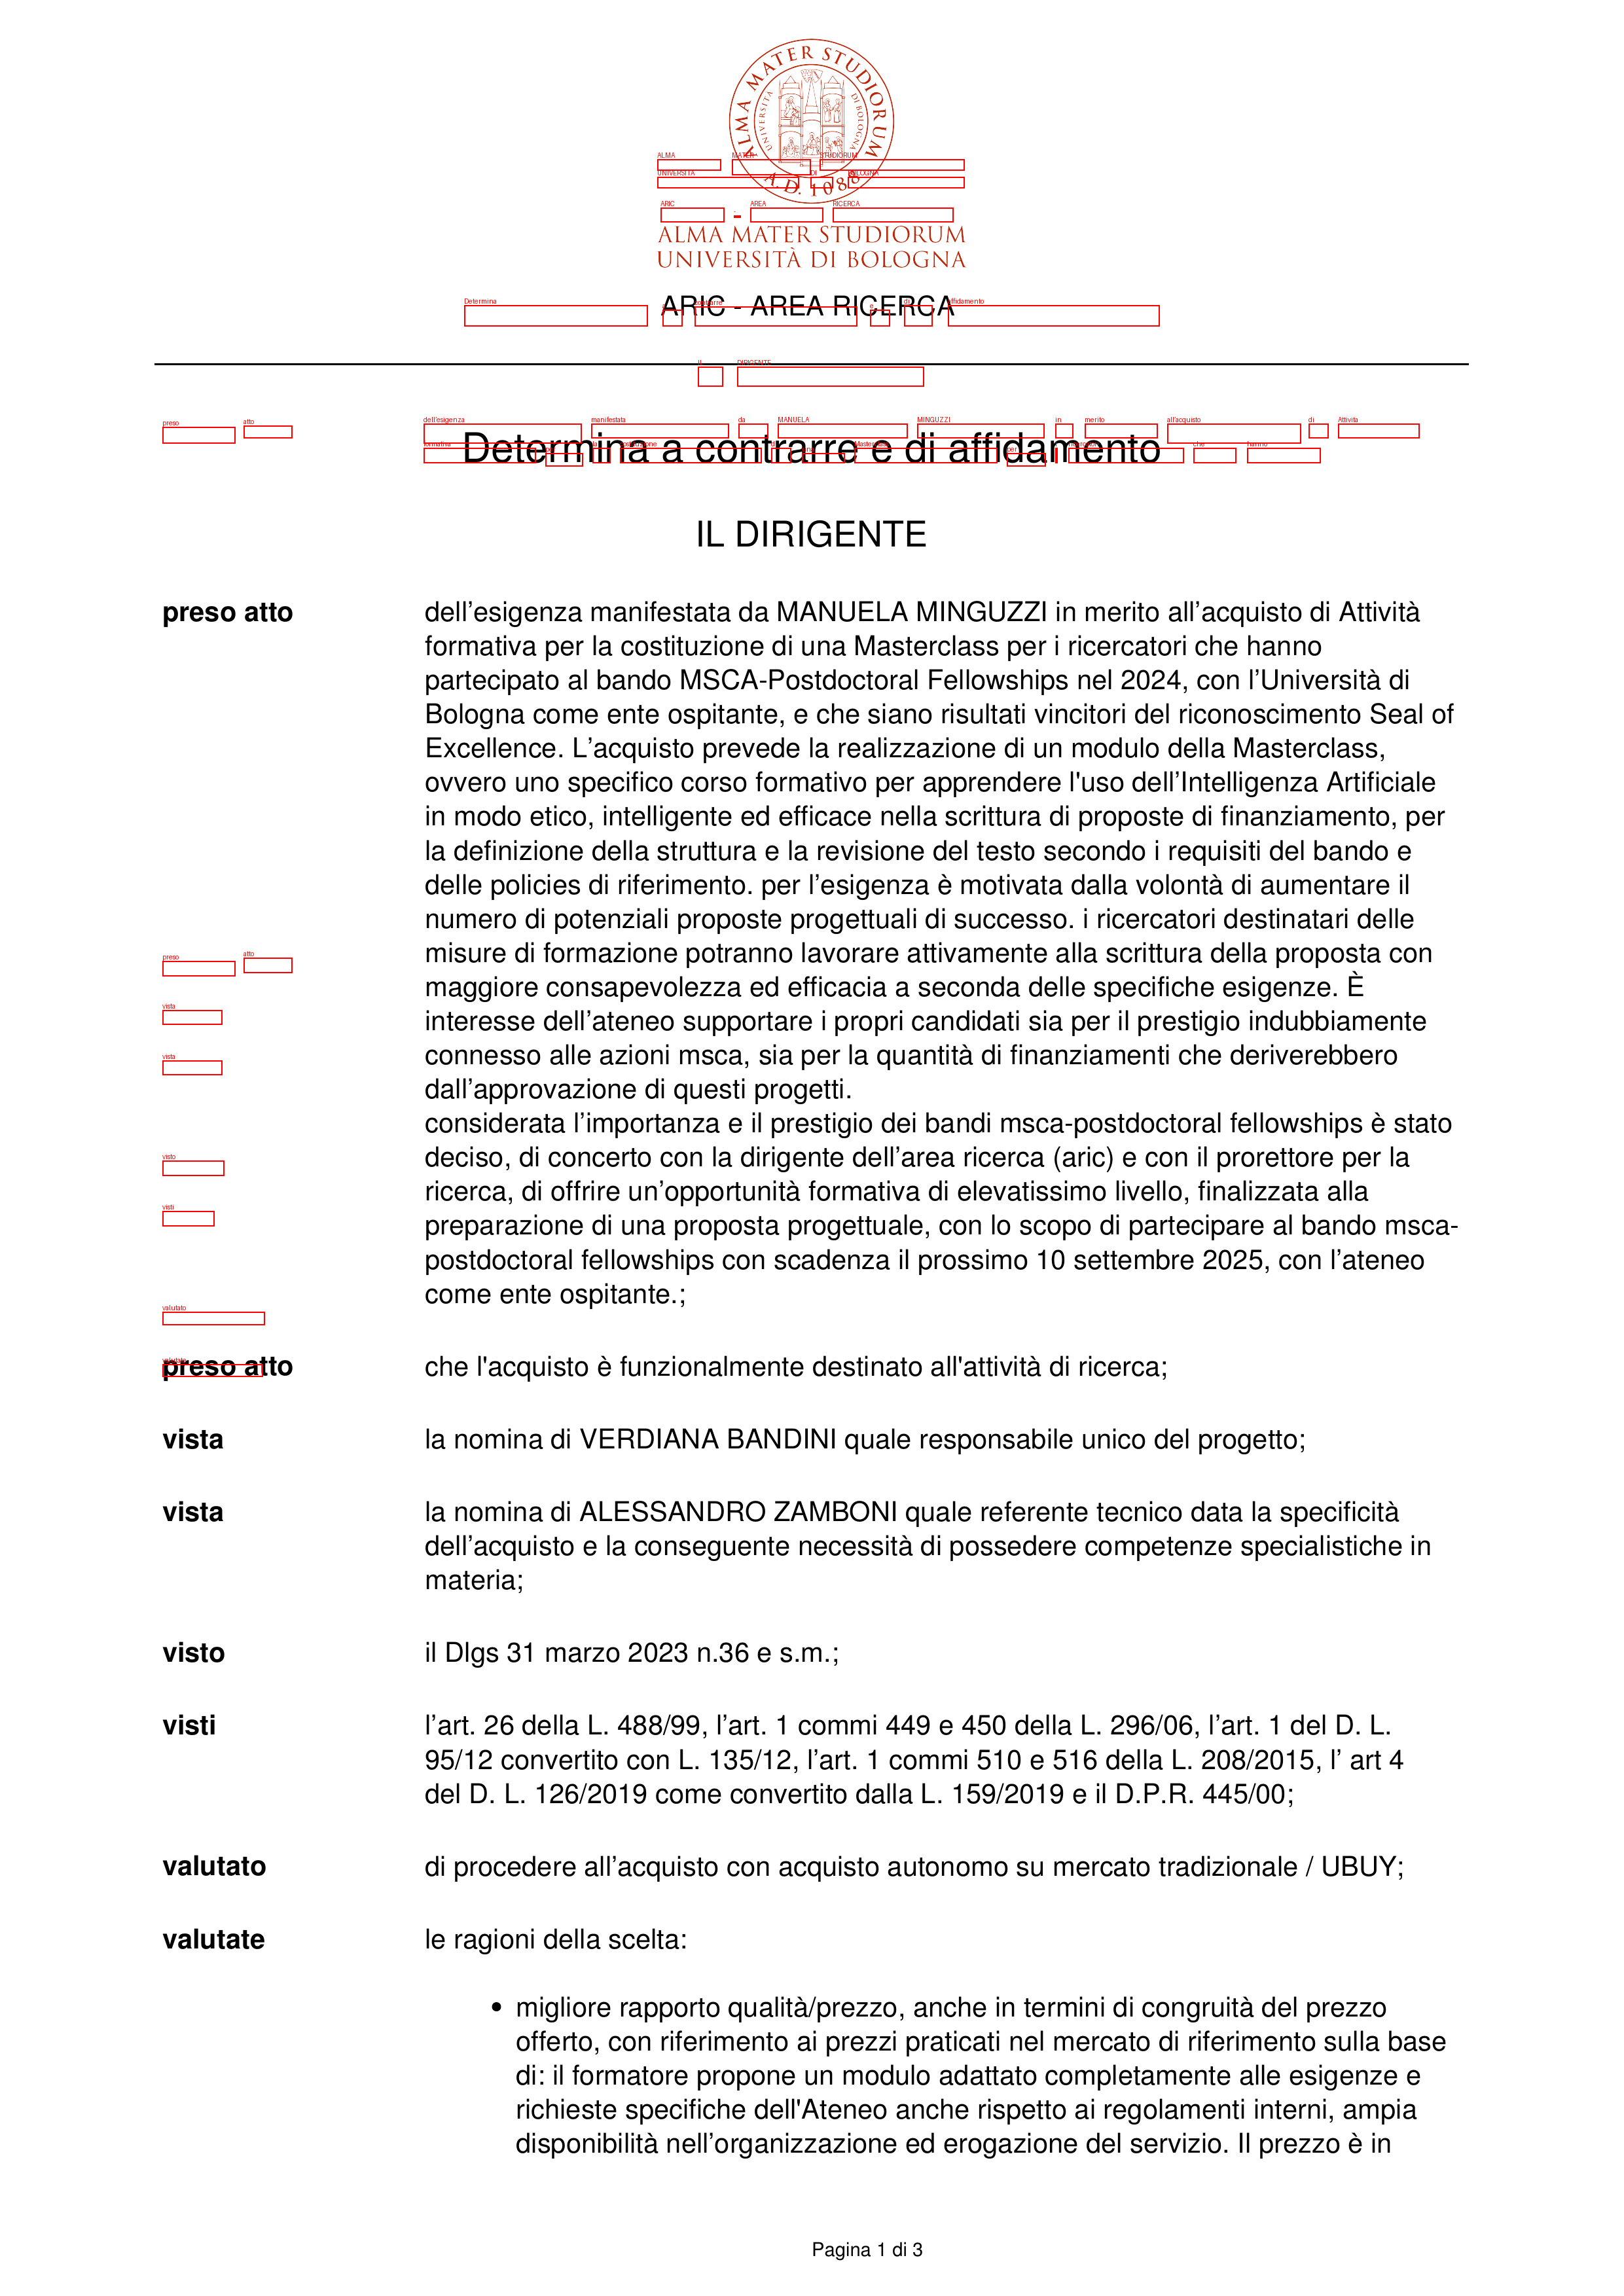

In [27]:
# Cella_09 

from PIL import ImageDraw, ImageFont

def show_entities(img_path, ocr_page, max_items=50):
    """
    Disegna un numero limitato di bounding box (max_items)
    sui token OCR per verificare la qualità dell'estrazione.
    """
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    draw = ImageDraw.Draw(img)

    for i, (tok, box) in enumerate(zip(ocr_page["tokens"], ocr_page["boxes"])):
        if i >= max_items:
            break
        x0, y0, x1, y1 = [int(c * w / 1000) for c in box]
        draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
        draw.text((x0, max(0, y0 - 12)), tok[:15], fill="red")  # tronca token lunghi

    display(img)

# Mostra solo i primi 50 token per incasinare la pagina
show_entities(png_paths[0], pages_ocr[0], max_items=50)


In [28]:
# Cella_10

import platform
import torch
import transformers
from pathlib import Path

env_text = f"""
name: pw-ai
channels:
  - defaults
dependencies:
  - python={platform.python_version()[:3]}
  - pip
  - pip:
    - torch=={torch.__version__}
    - transformers=={transformers.__version__}
    - pdf2image
    - pytesseract
    - Pillow
    - opencv-python
    - pyyaml
    - jinja2
    - pandas
    - datasets
"""

env_path = OUT / "environment.yml"
env_path.write_text(env_text.strip() + "\n", encoding="utf-8")
print("✅ File creato:", env_path)


✅ File creato: /home/ailgarrac/project-work-AISchool/notebooks/outputs/environment.yml
